<a href="https://colab.research.google.com/github/ftk1000/w2v_ftk1000/blob/master/w2v_tf_fast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [177]:
# w2v_tf_fast
import numpy as np
import pandas as pd
pd.options.display.max_columns = 500
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
import time
import re   # p = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', p)

def get_padding(x):
  return (np.max(x)-np.min(x))/20

def plot_words(w2v_df, ttl):
  # plot words according to their embedding
  x1 = np.array(w2v_df['x1'])
  x2 = np.array(w2v_df['x2'])
  # wrd = 
  x_axis_min, x_axis_max = np.min(x1)-get_padding(x1), np.max(x1)+get_padding(x1)
  y_axis_min, y_axis_max = np.min(x2)-get_padding(x2), np.max(x2)+get_padding(x2)

  plt.close()
  fig, ax = plt.subplots()
  plt.rcParams["figure.figsize"] = (10,10)
  # plt.figure(figsize=(10,10))

  plt.scatter(x1, x2, c='red', s=500, alpha=0.3)
  # plt.text(x1+.03, x2+.03, np.asarray(w2v_df['word']), fontsize=9)
  for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
      ax.annotate(word, (x1,x2 ), fontsize=14)
      
  plt.xlim(x_axis_min,x_axis_max)
  plt.ylim(y_axis_min,y_axis_max)
  plt.title(ttl, fontsize=18)
  plt.show()

In [194]:
# ix  =  w2v_df['word']=='кичлам'
# sum(ix)
# # w2v_df.loc[ix]

0

In [195]:
# w2v_df['word']

0        queen
1        woman
2         wise
3          boy
4       strong
5       prince
6       pretty
7          man
8         king
9     princess
10        girl
11       young
Name: word, dtype: object

In [178]:
text = "Балерина вдохновляет девочку. КИЧЛАМ сильный и ловкий. Штангист сильный мужчина. Балерина красивая женщина. Юниор ловкий штангист. \
Юниор молодой мужчина. Девочку учит балерина. "

# corpus = [s.lower().strip().split() for s in re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', text)[0].split('.')[:-1] ]
corpus = [s.lower().strip() for s in re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', text)[0].split('.')[:-1] ]
corpus

['балерина вдохновляет девочку',
 'кичлам сильный и ловкий',
 'штангист сильный мужчина',
 'балерина красивая женщина',
 'юниор ловкий штангист',
 'юниор молодой мужчина',
 'девочку учит балерина']

In [179]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be', 'и']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    return results

corpus = remove_stop_words(corpus)
sentences = [s.split(' ') for s in corpus]

vocab=[]
for ss in sentences:
  vocab += ss
vocab = sorted(set(words))
print(f'{len(vocab)} СЛОВАРЬ=', vocab)

word2int = {}
for i,word in enumerate(vocab):
    word2int[word] = i
print('word2int=', word2int)

WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])
df = pd.DataFrame(data, columns = ['input', 'label'])
print('df.shape =', df.shape)
print(sentences)
df.head(n=10)
# df.head(n=len(df))

13 СЛОВАРЬ= ['балерина', 'вдохновляет', 'девочку', 'женщина', 'кичлам', 'красивая', 'ловкий', 'молодой', 'мужчина', 'сильный', 'учит', 'штангист', 'юниор']
word2int= {'балерина': 0, 'вдохновляет': 1, 'девочку': 2, 'женщина': 3, 'кичлам': 4, 'красивая': 5, 'ловкий': 6, 'молодой': 7, 'мужчина': 8, 'сильный': 9, 'учит': 10, 'штангист': 11, 'юниор': 12}
df.shape = (42, 2)
[['балерина', 'вдохновляет', 'девочку'], ['кичлам', 'сильный', 'ловкий'], ['штангист', 'сильный', 'мужчина'], ['балерина', 'красивая', 'женщина'], ['юниор', 'ловкий', 'штангист'], ['юниор', 'молодой', 'мужчина'], ['девочку', 'учит', 'балерина']]


,input,label
0,балерина,вдохновляет
1,балерина,девочку
2,вдохновляет,балерина
3,вдохновляет,девочку
4,девочку,балерина
5,девочку,вдохновляет
6,кичлам,сильный
7,кичлам,ловкий
8,сильный,кичлам
9,сильный,ловкий


In [183]:
w2idx = pd.DataFrame.from_dict({ 'values': word2int.values(), 'word': word2int.keys() })
# print(w2idx.head())

import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import plot_model

ONE_HOT_DIM = len(vocab)
print('ONE_HOT_DIM = ', ONE_HOT_DIM)
# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word


# print(df.head())
print('word2int=', word2int)
# k=0
for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))
    # if k<5:
    #   Xtmp = to_one_hot_encoding(word2int[ x ])
    #   Ytmp = to_one_hot_encoding(word2int[ y ])
    #   print(x,'\t===>',Xtmp, '\t\t\t\t',  y ,'===>',Ytmp)
    #   k+=1


# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)
df['X_train']=list(X_train)
df['Y_train']=list(Y_train)
df.head()

ONE_HOT_DIM =  13
word2int= {'балерина': 0, 'вдохновляет': 1, 'девочку': 2, 'женщина': 3, 'кичлам': 4, 'красивая': 5, 'ловкий': 6, 'молодой': 7, 'мужчина': 8, 'сильный': 9, 'учит': 10, 'штангист': 11, 'юниор': 12}


,input,label,X_train,Y_train
0,балерина,вдохновляет,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,балерина,девочку,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,вдохновляет,балерина,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,вдохновляет,девочку,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,девочку,балерина,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


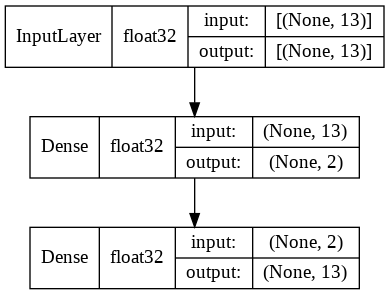

In [185]:
from keras import models
from keras import layers 
model = models.Sequential()
# https://www.tensorflow.org/api_docs/python/tf/keras/activations   # network.add( layers.Dense(2, activation='relu', input_shape=(12,) ) )
model.add( layers.Dense(2, activation='linear', input_shape=(ONE_HOT_DIM,) ) )
model.add( layers.Dense(ONE_HOT_DIM, activation='softmax' ) )
model.compile( optimizer='rmsprop', 
                 loss = 'categorical_crossentropy', 
                 metrics = ['accuracy'] )
plot_model(model, show_shapes=1, show_dtype=1,show_layer_names=0)              # plot_model(model, show_shapes=1, show_layer_names=1)

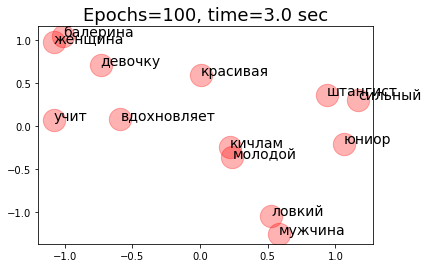

In [186]:
%matplotlib inline
EPOCHS = 100
def model_fit_n_show(model, eps=EPOCHS):
  sttime = time.time()
  model.fit( X_train, Y_train, epochs=eps, batch_size=1, verbose=0)
  d2 = pd.DataFrame(  model.weights[0].numpy(),  columns = ['x1', 'x2'] )
  w2v_df = pd.concat( [w2idx,d2],axis=1 )
  # ?network.fit
  endtime = time.time()
  ttl = f'Epochs={eps}, time={np.round(endtime-sttime)} sec'
  # print(ttl)
  plot_words(w2v_df, ttl)
  return model, w2v_df

model, w2v_df = model_fit_n_show(model,eps=100)

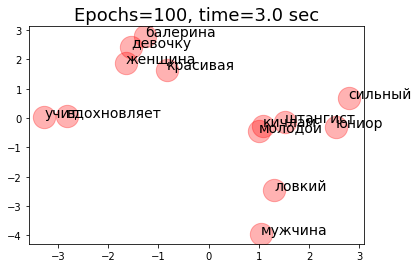

In [190]:
%matplotlib inline
model, w2v_df = model_fit_n_show(model,eps=100)

In [196]:
model.weights

[<tf.Variable 'dense_24/kernel:0' shape=(13, 2) dtype=float32, numpy=
 array([[-1.9787829 ,  4.540334  ],
        [-5.851698  , -0.60962975],
        [-2.143911  ,  3.2429597 ],
        [-1.9211073 ,  2.173018  ],
        [ 1.6447995 , -0.29285327],
        [-1.4760334 ,  1.8338789 ],
        [ 2.3768356 , -3.8012779 ],
        [ 1.5304296 , -0.543195  ],
        [ 2.5075989 , -5.330831  ],
        [ 5.8087497 ,  1.3569987 ],
        [-6.0519953 , -0.4945318 ],
        [ 2.0965166 , -0.5127283 ],
        [ 5.050314  , -0.22363283]], dtype=float32)>,
 <tf.Variable 'dense_24/bias:0' shape=(2,) dtype=float32, numpy=array([0.5804085, 1.0027529], dtype=float32)>,
 <tf.Variable 'dense_25/kernel:0' shape=(2, 13) dtype=float32, numpy=
 array([[-2.3813133, -1.7015824, -2.3906238, -1.777836 , -1.1864463,
         -1.794314 , -1.0967922, -1.2571747, -1.1102883, -1.4823711,
         -1.6969148, -1.1276304, -1.4978236],
        [-1.5498667, -1.0334162, -1.5659984, -1.1571281, -1.2751447,
         -

In [7]:
network.get_weights()

[array([[-0.8821549 , -1.4367647 ],
        [-0.4317497 , -0.6353622 ],
        [-0.00896321,  0.18075645],
        [ 0.9594549 ,  0.83846915],
        [ 0.58997566,  1.3291379 ],
        [ 0.8794094 ,  0.5211912 ],
        [-0.03035845, -0.32102278],
        [-0.16031314,  1.1556215 ],
        [ 1.0769519 ,  0.5442217 ],
        [-0.7208887 ,  0.6148145 ],
        [-0.85221744, -0.11148982],
        [ 0.44631815, -0.39832088]], dtype=float32),
 array([-0.03641769,  0.14972737], dtype=float32),
 array([[-5.4920441e-01, -4.7857992e-02, -4.4810253e-01,  4.9534869e-01,
         -1.7283849e-01,  6.6052622e-01, -7.1217962e-02,  5.8681178e-01,
          4.6032926e-01, -7.1006489e-01, -7.4877784e-02, -2.1995977e-01],
        [-9.0066023e-02, -8.3207017e-01, -8.7245488e-01, -2.2657964e-01,
          3.3058473e-01, -1.6703460e-01, -7.5321823e-01,  2.5331837e-01,
          2.9353699e-01, -8.3415145e-01, -9.2688632e-01, -6.4322515e-04]],
       dtype=float32),
 array([-0.33217296, -0.42621833, -1

In [8]:
# # https://ai-pool.com/d/how-to-get-the-weights-of-keras-model-
# for layer in model.layers:
#     weights = layer.get_weights() # list

# from keras.models import Sequential
# model = Sequential()
# weights = model.get_weights() # returs a numpy list of weights  

print('WEIGHT MATRICES:')
for layer in network.layers:
    weights = layer.get_weights() # list
    print(weights[0].shape)
    print(weights[0])

print('\n\nBIASES:')
for layer in network.layers:
    bias = layer.bias # list
    print(bias.shape)
    print(bias)    

WEIGHT MATRICES:
(12, 2)
[[-0.8821549  -1.4367647 ]
 [-0.4317497  -0.6353622 ]
 [-0.00896321  0.18075645]
 [ 0.9594549   0.83846915]
 [ 0.58997566  1.3291379 ]
 [ 0.8794094   0.5211912 ]
 [-0.03035845 -0.32102278]
 [-0.16031314  1.1556215 ]
 [ 1.0769519   0.5442217 ]
 [-0.7208887   0.6148145 ]
 [-0.85221744 -0.11148982]
 [ 0.44631815 -0.39832088]]
(2, 12)
[[-5.4920441e-01 -4.7857992e-02 -4.4810253e-01  4.9534869e-01
  -1.7283849e-01  6.6052622e-01 -7.1217962e-02  5.8681178e-01
   4.6032926e-01 -7.1006489e-01 -7.4877784e-02 -2.1995977e-01]
 [-9.0066023e-02 -8.3207017e-01 -8.7245488e-01 -2.2657964e-01
   3.3058473e-01 -1.6703460e-01 -7.5321823e-01  2.5331837e-01
   2.9353699e-01 -8.3415145e-01 -9.2688632e-01 -6.4322515e-04]]


BIASES:
(2,)
<tf.Variable 'dense/bias:0' shape=(2,) dtype=float32, numpy=array([-0.03641769,  0.14972737], dtype=float32)>
(12,)
<tf.Variable 'dense_1/bias:0' shape=(12,) dtype=float32, numpy=
array([-0.33217296, -0.42621833, -1.3568696 , -0.7380769 , -1.1513128 ,


In [9]:
  bias.shape

TensorShape([12])

In [10]:
bias.value

<bound method BaseResourceVariable.value of <tf.Variable 'dense_1/bias:0' shape=(12,) dtype=float32, numpy=
array([-0.33217296, -0.42621833, -1.3568696 , -0.7380769 , -1.1513128 ,
       -0.78445655, -2.0894501 , -0.67352444, -0.47574165, -0.7236303 ,
       -0.66735363, -0.02232221], dtype=float32)>>

In [11]:
layer.get_weights

<bound method Layer.get_weights of <tensorflow.python.keras.layers.core.Dense object at 0x7fa40b6d0850>>

In [12]:
d2 = pd.DataFrame(  network.weights[0].numpy(),  columns = ['x1', 'x2'] )
w2v_df = pd.concat( [w2idx,d2],axis=1 )
w2v_df

,values,word,x1,x2
0,0,queen,-0.882155,-1.436765
1,1,woman,-0.431750,-0.635362
2,2,wise,-0.008963,0.180756
3,3,boy,0.959455,0.838469
4,4,strong,0.589976,1.329138
5,5,prince,0.879409,0.521191
6,6,pretty,-0.030358,-0.321023
7,7,man,-0.160313,1.155622
8,8,king,1.076952,0.544222
9,9,princess,-0.720889,0.614815


In [79]:
# import nltk
# from nltk import tokenize
# tokenize.sent_tokenize(p)



['king is a strong man',
 'queen is a beutiful woman',
 'boy is a young man',
 'girl is a young woman',
 'prince is a young king',
 'princess is a young queen',
 'man is strong',
 'woman is pretty',
 'prince is a boy will be king',
 'princess is a girl will be queen']

In [22]:
np.asarray(w2v_df['word'])

array(['queen', 'woman', 'wise', 'boy', 'strong', 'prince', 'pretty',
       'man', 'king', 'princess', 'girl', 'young'], dtype=object)

In [48]:
# [(x, y) for x in [1,2,3] for y in [3,1,4] if x != y]
sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
sentences


[['king', 'strong', 'man'],
 ['queen', 'wise', 'woman'],
 ['boy', 'young', 'man'],
 ['girl', 'young', 'woman'],
 ['prince', 'young', 'king'],
 ['princess', 'young', 'queen'],
 ['man', 'strong'],
 ['woman', 'pretty'],
 ['prince', 'boy', 'king'],
 ['princess', 'girl', 'queen']]

In [50]:

sentences

[['king', 'strong', 'man'],
 ['queen', 'wise', 'woman'],
 ['boy', 'young', 'man'],
 ['girl', 'young', 'woman'],
 ['prince', 'young', 'king'],
 ['princess', 'young', 'queen'],
 ['man', 'strong'],
 ['woman', 'pretty'],
 ['prince', 'boy', 'king'],
 ['princess', 'girl', 'queen']]

In [90]:
layer.bias

<tf.Variable 'dense_9/bias:0' shape=(12,) dtype=float32, numpy=
array([-3.2867498, -5.0678787, -3.9071274, -3.654713 , -2.8057609,
       -2.935007 , -2.2635174, -4.059876 , -2.541485 , -3.355741 ,
       -2.9069571, -2.9273875], dtype=float32)>

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

In [25]:
ww

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

In [29]:
ww=set();
[ww.union((set(ss))) for ss in [s.split(' ') for s in corpus]]

[{'king', 'man', 'strong'},
 {'queen', 'wise', 'woman'},
 {'boy', 'man', 'young'},
 {'girl', 'woman', 'young'},
 {'king', 'prince', 'young'},
 {'princess', 'queen', 'young'},
 {'man', 'strong'},
 {'pretty', 'woman'},
 {'boy', 'king', 'prince'},
 {'girl', 'princess', 'queen'}]